In [1]:
# Library imports
import numpy as np
import pickle
import matplotlib.pyplot as plt

import tools
from train import generate_graph, train

In [2]:
# Fix random seed for reproducibility
np.random.seed(628496)

# Stop on errors
np.seterr('raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# Load the anonymised data
file_path = 'datasets\\real_data_graph.pkl'
with open(file_path, 'rb') as f:
    edges_by_day, last_day, raw_accounts = pickle.load(f)


In [4]:
# Count the number of generated edges to validate that the correct data is loaded
count_edges = sum(len(day) for day in edges_by_day.values())
print(f'There were {count_edges} edges generated.')

There were 295 edges generated.


In [5]:
# Add three additional (4, 7) edges, summing to around 5% of the
# original aggregate value of (4, 7) edges

# Count edges (4, 7)
count_target_edges = 0
count_added_value = 0
for day in sorted(list(edges_by_day.keys())):
    edges = edges_by_day[day]
    count_target_edges += len([
        edge
        for edge in edges
        if edge[0] == 4 and edge[1] == 7
    ])
    count_added_value += sum(
        edge[2]
        for edge in edges
        if edge[0] == 4 and edge[1] == 7
    )

count_added_edges = 3
count_added_value /= count_added_edges

# Choose random days
random_days = np.random.randint(0, last_day, count_added_edges)

# Add the edges to those days
for day in random_days:
    if day not in edges_by_day:
        edges_by_day[day] = []

    edges_by_day[day].append((4, 7, count_added_value / count_added_edges))


print(f'{count_added_edges} edges were added with a total value of £{count_added_value:,.0f}')

3 edges were added with a total value of £69,048


In [6]:
# Count the number of generated edges
count_edges = sum(len(day) for day in edges_by_day.values())
print(f'There are now {count_edges} edges.')

There are now 298 edges.


In [7]:
# Create a graph object with the generated accounts
graph = generate_graph(
    raw_accounts=raw_accounts,
    edges_by_day=edges_by_day,
    last_day=last_day,
    node_dimension=256,
    graph_kwords={
        'causal_learning_rate': 0.001,
        'spontaneous_learning_rate': 10**(-6),
        'weight_regularisation_rate': 10**(-6)
    }
)

In [8]:
# Train on the tainted data
probabilities = train(
    graph, edges_by_day, last_day, iterations=200,
    plot_log_likelihood=False, use_tqdm=True,
    spontaneous_learning_startpoint=150
    )

100%|██████████| 200/200 [2:30:21<00:00, 45.11s/it]  


In [9]:
# Save the trained model and results
with open('saved_results//added_edges_anonymised_results.pkl', 'wb') as f:
    pickle.dump((probabilities, graph), f)

In [10]:
# Find the probability that the number of a particular edge type on a particular
# day is higher than expected (suggesting edges have been added)
all_probabilities = tools.return_probabilities_of_added_edges(graph, edges_by_day)

100%|██████████| 38/38 [00:01<00:00, 27.96it/s]


In [11]:
print(f'There were {len(all_probabilities)} day-edge pairs.')

There were 81 day-edge pairs.


In [12]:
# Sort the probabilities from most to least suspicious
all_probabilities.sort(key=lambda x: x[3], reverse=True)

In [13]:
# Find the locations of the added edges and the genuine edges
added_rank = []
notadded_rank = []
for i, edge in enumerate(all_probabilities):
    if edge[0] in random_days and edge[1] == 4 and edge[2] == 7:
        print(f'Item {i+1} of {len(all_probabilities)}:', edge)
        added_rank.append(i)
    elif edge[1] == 4 and edge[2] == 7:
        notadded_rank.append(i)

Item 20 of 81: (327, 4, 7, 0.9999990000005)
Item 26 of 81: (140, 4, 7, 0.9999989399823755)
Item 56 of 81: (156, 4, 7, 0.9938665887740719)


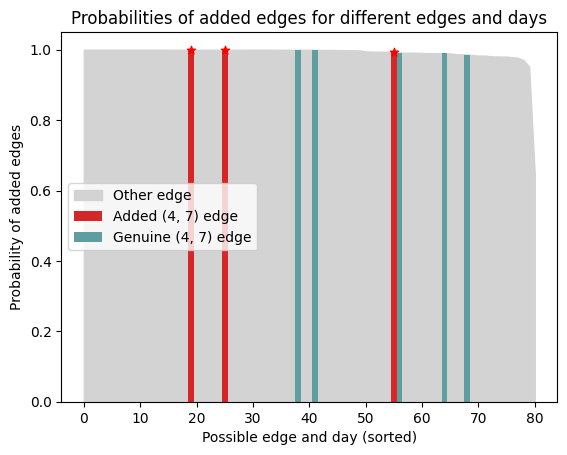

In [14]:
# Plot all the probabilities, highlighting which ones were added and
# which were genuine of the same edge
plt.fill_between(
    np.arange(len(all_probabilities)),
    np.zeros(len(all_probabilities)),
    np.array([edge[3] for edge in all_probabilities]),
    color='#d3d3d3',
    label='Other edge'
)
plt.bar(
    added_rank,
    [all_probabilities[i][3] for i in added_rank],
    width=1.0,
    color='#d62728',
    label='Added (4, 7) edge'
)
plt.bar(
    notadded_rank,
    [all_probabilities[i][3] for i in notadded_rank],
    width=1.0,
    color='#5f9ea0',
    label='Genuine (4, 7) edge'
)
plt.scatter(
    added_rank,
    [all_probabilities[i][3] for i in added_rank],
    marker='*', c='red'
)

plt.legend(loc='center left')

plt.xlabel('Possible edge and day (sorted)')
plt.ylabel('Probability of added edges')
plt.title('Probabilities of added edges for different edges and days')

plt.show()

In [15]:
print(f'Average added rank: {np.mean([i+1 for i in added_rank])}')
print(f'Genuine average rank: {np.mean([i+1 for i in notadded_rank])}')

Average added rank: 34.0
Genuine average rank: 54.4
